In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypalettes import load_cmap
from highlight_text import fig_text

# Load Dataset

In [7]:
df = pd.read_csv(r"..\data\holiday_interests_by_country_gender.csv")  

df = (

    # reshape the dataframe from wide to long format
    df.melt(
        id_vars=["gender", "address4"]      # columns to keep fixed (repeated for each row)
    )

    # rename columns for better readability and visualisation
    .rename(
        columns={
            "address4": "country",
            "variable": "holiday_interest",
            "value": "count"
        }
    )

    # optional: clean format of holiday interest names for display
    .assign(
        holiday_interest=lambda x: (
            x["holiday_interest"]
            .str.replace("_Sum", "", regex=False)
            .str.replace("_", " ", regex=False)
            .str.title()
        )
    )

    # group by holiday interest and sum the counts across all entries (analysis excludes gender and country)
    .groupby(["holiday_interest", "country"])["count"].sum().reset_index()

    # transpose gender values (male/female) into separate columns
    .pivot(
        index="holiday_interest",
        columns="country",
        values="count"
    )

    # sort by total interest (descending)
    .assign(total=lambda x: x.sum(axis=1, numeric_only=True))   # calculate totals across each row
    .sort_values("total", ascending=False)

    # remove resulting gender index column
    .reset_index().rename_axis(None, axis=1)
)

df

,holiday_interest,England,Northern Ireland,Scotland,Wales,total
0,Scuba Diving,16328,340,1381,915,18964
1,Trail Walking,16198,324,1466,865,18853
2,Mountaineering,16185,336,1420,896,18837
3,Dancing,10941,240,979,601,12761
4,Mountain Biking,10958,214,959,624,12755
5,Sightseeing,10941,225,970,614,12750
6,Hiking,10885,228,944,625,12682
7,Skiing,5675,110,503,272,6560
8,Climbing,5560,114,510,310,6494
9,Snowboarding,5424,111,538,308,6381


# Frequency Counts of Holiday Interests by Country

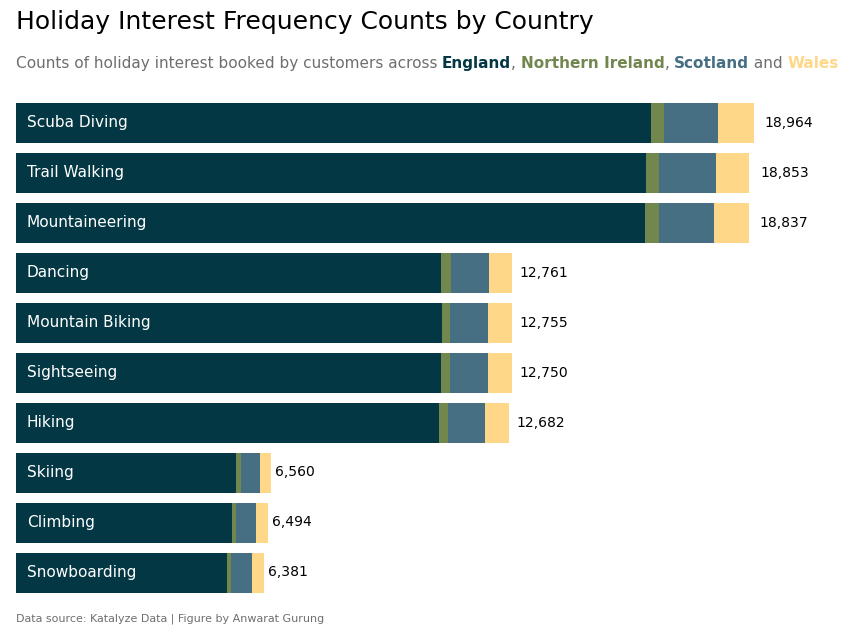

In [32]:
TOP_N = 10   # max 14 unique holiday interests in the dataset

df = df.head(TOP_N).sort_values(by="total")   # filter for the top N holiday interests

# choose a colour palette
cmap = load_cmap("Acadia")
colours = cmap.colors

england_colour = colours[1]
ni_colour = colours[2]
scotland_colour = colours[3]
wales_colour = colours[0]

fig, ax = plt.subplots(figsize=(10, 7))

# axes customisation
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax.tick_params(length=0)
ax.set_xticks([])

# layout parameters
bar_height = 0.8
y_pos = np.arange(df.shape[0])

# stacked horizontal bars
ax.barh(
    y=y_pos,
    width=df["England"],
    height=bar_height,
    color=england_colour,
)

ax.barh(
    y=y_pos,
    width=df["Northern Ireland"],
    left=df["England"],
    height=bar_height,
    color=ni_colour,
)

ax.barh(
    y=y_pos,
    width=df["Scotland"],
    left=df["England"] + df["Northern Ireland"],
    height=bar_height,
    color=scotland_colour,
)

ax.barh(
    y=y_pos,
    width=df["Wales"],
    left=df["England"] + df["Northern Ireland"] + df["Scotland"],
    height=bar_height,
    color=wales_colour,
)

# holiday interest labels on y-axis
ax.set_yticks(y_pos)
ax.tick_params(axis="y", length=0, pad=8)

# remove default y-axis labels
ax.set_yticks([])
ax.set_yticklabels([])

# add holiday interest labels inside the right end of each bar
for i, (label, total) in enumerate(zip(df["holiday_interest"], df["total"])):
    ax.text(
        x=df["total"].max() * 0.015,   # slightly inside the right edge
        y=y_pos[i],
        s=label,
        ha="left",
        va="center",
        fontsize=11,
        color="white"
    )
    
# annotate total value at the right end of each stacked bar
for i, total in enumerate(df["total"]):
    ax.text(
        x=total * 1.015,
        y=y_pos[i],
        s=f"{int(total):,}",
        ha="left",
        va="center",
        fontsize=10,
        color="black"
    )

# set main title positioning
x_value, y_value = 0.125, 0.95
fig.text(
    x=x_value, y=y_value,
    s="Holiday Interest Frequency Counts by Country",
    size=18,
)

# chart subtitle
fig_text(
    x=x_value, y=y_value * 0.96,
    s="Counts of holiday interest booked by customers across <England>, <Northern Ireland>, <Scotland> and <Wales>",
    highlight_textprops=[
        {"color": england_colour, "weight": "bold"},
        {"color": ni_colour, "weight": "bold"},
        {"color": scotland_colour, "weight": "bold"},
        {"color": wales_colour, "weight": "bold"},
    ],
    fontsize=11,
    color="#6e6e6e"
)

# chart caption
fig.text(
    x_value,
    0.1,
    "Data source: Katalyze Data | Figure by Anwarat Gurung",
    ha="left",
    va="bottom",
    fontsize=8,
    color="#6e6e6e",
)

plt.savefig("../images/holiday_interest_counts_by_country.png", dpi=200, bbox_inches="tight")

plt.show()